In [1]:
#!pip3 -qq install torch==0.4.1
#!pip install -qq bokeh==0.13.0
!wget -O surnames.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1ji7dhr9FojPeV51dDlKRERIqr3vdZfhu"

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети

## Классификация фамилий

Теперь - по языкам:

In [3]:
data, labels = [], []
with open('surnames.txt') as f:
    for line in f:
        surname, lang = line.strip().split('\t')
        data.append(surname)
        labels.append(lang)

for i in np.random.randint(0, len(data), 10):
    print(data[i], labels[i])

Mikhnev Russian
Morcos Arabic
Morrow English
Berezinsky Russian
Badyaev Russian
Teale English
Prigorodov Russian
Greening English
Jankevich Russian
Bahin Russian


### Разминка

Проверьте свои знания - попробуйте самостоятельно предсказать, к какому языку относится фамилия :)

In [4]:
from sklearn.utils.class_weight import compute_class_weight

def test_generator():
    classes = np.unique(labels)
    weights = compute_class_weight('balanced', classes, labels)
    classes = {label: ind for ind, label in enumerate(classes)}

    probs = np.array([weights[classes[label]] for label in labels])
    probs /= probs.sum()

    ind = np.random.choice(np.arange(len(data)), p=probs)
    yield data[ind]
    
    while True:
        new_ind = np.random.choice(np.arange(len(data)), p=probs)
        yield labels[ind], data[new_ind]
        ind = new_ind
        
gen = test_generator()
question = next(gen)

Запускайте, смотрите на фамилию, которая выведется - и выбирайте язык в выпадающем списке.

In [6]:
#@title Проверим себя (или адекватность данных) { run: "auto" }
answer = "Vietnamese" #@param ["Arabic", "Chinese", "Czech", "Dutch", "English", "French", "German", "Greek", "Irish", "Italian", "Japanese", "Korean", "Polish", "Portuguese", "Russian", "Scottish", "Spanish", "Vietnamese"]

correct_answer, question = next(gen)

if 'correct_count' not in globals():
    correct_count = 0
    total_count = 0
else:
    if answer == correct_answer:
        print('You are correct', end=' ')
        correct_count += 1
    else:
        print("No, it's", correct_answer, end=' ')

    total_count += 1
    print('({} / {})'.format(correct_count, total_count))
    
print('Next surname:', question)

No, it's Korean (0 / 1)
Next surname: Bao


### Разбиение данных

Для начала нужно построить сплит данных на трейн/тест. Сложность в том, что классы распределены неравномерны, а отрезать нужно от каждого класса пропорциональное количество данных на тест. Для этого нужно использовать `stratify` параметр функции `train_test_split` (либо `StratifiedShuffleSplit`, либо, при большом желании, `GroupShuffleSplit`).

In [7]:
from sklearn.model_selection import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(
    data, labels, test_size=0.3, stratify=labels, random_state=42
)

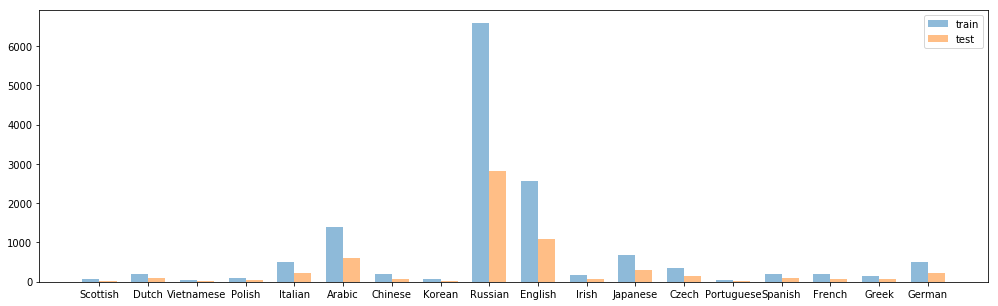

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

langs = set(labels)

train_distribution = Counter(labels_train)
train_distribution = [train_distribution[lang] for lang in langs]

test_distribution = Counter(labels_test)
test_distribution = [test_distribution[lang] for lang in langs]

plt.figure(figsize=(17, 5))

bar_width = 0.35
plt.bar(np.arange(len(langs)), train_distribution, bar_width, align='center', alpha=0.5, label='train')
plt.bar(np.arange(len(langs)) + bar_width, test_distribution, bar_width, align='center', alpha=0.5, label='test')
plt.xticks(np.arange(len(langs)) + bar_width / 2, langs)
plt.legend()
    
plt.show()

### Бейзлайн

Всегда надо начинать с бейзлайна - воспользуемся нашей любимой парой vectorizer-logistic regression:

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char', ngram_range=(1, 4))),
    ('log_regression', LogisticRegression())
])

model.fit(data_train, labels_train)

/home/alexander/miniconda3/envs/temp3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/alexander/miniconda3/envs/temp3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4), preprocessor=None, stop_words=None,
       ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

Какие метрики будем считать? Тут многоклассовая классификация, поэтому всё очень неоднозначно.

Имеет смысл посмотреть на accuracy и на F1-score'ы для каждого класса.

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

preds = model.predict(data_test)

print('Accuracy = {:.2%}'.format(accuracy_score(labels_test, preds)))
print('Classification report:')
print(classification_report(labels_test, preds))

Accuracy = 83.45%
Classification report:
              precision    recall  f1-score   support

      Arabic       0.90      1.00      0.95       600
     Chinese       0.65      0.57      0.61        80
       Czech       0.58      0.28      0.38       156
       Dutch       0.85      0.49      0.62        89
     English       0.72      0.84      0.78      1101
      French       0.52      0.19      0.28        83
      German       0.61      0.51      0.55       217
       Greek       0.93      0.64      0.76        61
       Irish       0.65      0.44      0.53        70
     Italian       0.74      0.72      0.73       213
    Japanese       0.91      0.90      0.90       297
      Korean       0.25      0.14      0.18        28
      Polish       0.61      0.33      0.43        42
  Portuguese       0.27      0.14      0.18        22
     Russian       0.92      0.96      0.94      2823
    Scottish       0.00      0.00      0.00        30
     Spanish       0.48      0.28      0

F1-score'ы можно агрегировать разными способами:
- weighted - это как посчитал classification_report - если нам важнее предсказывать хорошо более частотные фамилии
- macro - простое усреднение - если важно предсказывать все, независимо от того, сколько каждого класса в тестовой выборке
- micro - обычный подсчет F1-score по суммам всех true positive, false positive и false negative

Weighted и micro - две метрики, учитывающие дисбаланс классов. Но в нашем случае неочевидно, есть ли дисбаланс, да?

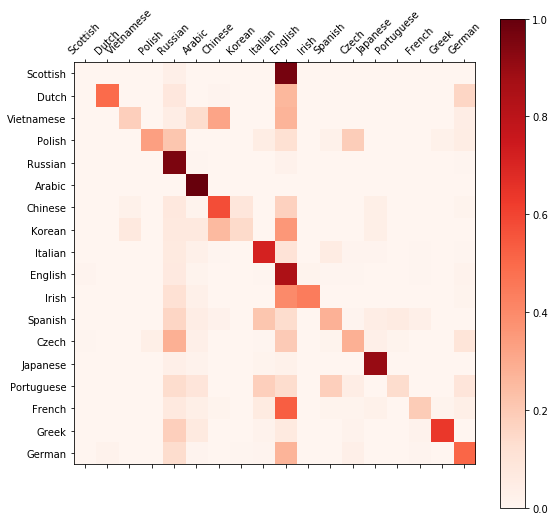

In [11]:
import matplotlib.ticker as ticker

label_names = list(set(labels_test))
confusion = confusion_matrix(labels_test, preds, labels=label_names).astype(np.float)
confusion /= confusion.sum(axis=-1, keepdims=True)

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion, cmap='Reds')
fig.colorbar(cax)

ax.set_xticklabels([''] + label_names, rotation=45)
ax.set_yticklabels([''] + label_names)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## Simple RNN

Основная прелесть RNN - расшаренные параметры. Посмотрите на картинку:

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg " ")

*From [(The Unreasonable Effectiveness of Recurrent Neural Networks)](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Первый пример - это обычная полносвязная сеть. Каждый следующий демонстрирует обработку некоторой последовательности произвольной длины (красные прямоугольнички) и генерацию выходной последовательности, также произвольной длины (синие прямоугольники).

При этом зеленые прямоугольники в каждом рисунке - это одни и те же веса. Получается, мы, с одной стороны, обучаем очень-очень глубокую сеть (если посмотреть на неё перевернутую), а с другой - строго ограниченное количество параметров.

---
Напишем сразу простую RNN!

Напомню, делает она примерно вот это:

![rnn-unrolled](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png " ")

*From [(Understanding LSTM Networks)](http://colah.github.io/posts/2015-08-Understanding-LSTMs)*

Вообще говоря, можно придумать много вариаций на тему такой реализации. В нашем случае, обработка будет такой:
$$h_t = tanh(W_h [h_{t-1}; x_t] + b_h)$$

$h_{t-1}$ - скрытое состояние, полученное на предыдущем шаге, $x_t$ - входной вектор. $[h_{t-1}; x_t]$ - простая конкатенация векторов. Всё как на картинке!

Проверим нашу сеть на очень простой задаче: заставим её говорить индекс первого элемента в последовательности.

Т.е. для последовательности `[1, 2, 1, 3]` сеть должна предсказывать `1`.

Начнем с генерации батча.

In [12]:
def generate_data(batch_size=128, seq_len=5):
    data = torch.randint(0, 10, size=(seq_len, batch_size), dtype=torch.long)
    return data, data[0]

X_val, y_val = generate_data()
X_val, y_val

(tensor([[4, 8, 9, 1, 1, 8, 5, 5, 5, 5, 1, 9, 8, 7, 2, 1, 1, 1, 1, 8, 9, 8, 3, 1,
          3, 1, 1, 3, 7, 7, 6, 6, 5, 4, 0, 9, 9, 6, 3, 7, 5, 6, 6, 5, 0, 6, 5, 5,
          7, 3, 8, 6, 7, 4, 5, 1, 7, 8, 6, 0, 2, 0, 6, 5, 5, 2, 6, 2, 6, 9, 9, 8,
          7, 4, 6, 1, 1, 2, 0, 4, 3, 1, 2, 4, 9, 3, 0, 4, 1, 7, 5, 6, 2, 3, 8, 0,
          4, 0, 8, 3, 9, 4, 6, 9, 6, 2, 1, 7, 0, 1, 3, 0, 8, 8, 0, 4, 5, 7, 4, 2,
          2, 4, 7, 4, 0, 1, 8, 3],
         [3, 2, 3, 9, 2, 1, 0, 9, 0, 7, 9, 3, 3, 5, 5, 5, 9, 5, 5, 6, 3, 4, 7, 0,
          6, 7, 8, 4, 6, 3, 5, 1, 3, 4, 6, 9, 6, 6, 9, 0, 5, 0, 0, 5, 8, 7, 1, 0,
          0, 9, 4, 2, 7, 5, 6, 8, 7, 1, 7, 0, 5, 0, 9, 1, 5, 6, 5, 4, 9, 8, 9, 8,
          3, 8, 1, 0, 6, 4, 2, 8, 5, 4, 0, 1, 7, 5, 9, 3, 2, 3, 1, 8, 5, 9, 8, 1,
          1, 7, 1, 5, 2, 1, 6, 0, 5, 0, 1, 0, 5, 9, 3, 4, 5, 8, 2, 9, 5, 4, 2, 2,
          9, 2, 5, 0, 0, 2, 8, 1],
         [5, 2, 7, 8, 4, 5, 2, 3, 4, 5, 5, 8, 2, 1, 4, 1, 9, 8, 2, 7, 4, 3, 6, 0,
          6, 0, 5, 8, 1, 2, 

Обратите внимание, что батч имеет размерность `(sequence_length, batch_size, input_size)`. Все `RNN` в pytorch работают с таким форматом по умолчанию.

Сделано это из соображений производительности, но при желании можно поменять такое поведение с помощью аргумента `batch_first`.

**Задание** Реализуйте класс `SimpleRNN`, выполняющий рассчеты по формуле выше.

In [168]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self._hidden_size = hidden_size
        self.linear = nn.Linear(input_size +  hidden_size, hidden_size)

    def forward(self, inputs, hidden=None):
        seq_len, batch_size = inputs.shape[:2]
        if hidden is None:
            hidden = inputs.new_zeros((batch_size, self._hidden_size))
        
        for i in range(seq_len):
            x = torch.cat([hidden, inputs[i]], dim = 1)
            hidden = F.relu(self.linear(x))
            #<apply linear layer to concatenation of current input (inputs[i]) and hidden>

        return hidden

Должно стать понятно, почему полезно иметь первой размерностью seq_len - нужно уметь брать `inputs[i]` - подбатч, относящийся к данному таймстемпу. Если бы данные были расположены по-другому, эта операция была бы сильно дороже.

**Задание** Реализуйте класс `MemorizerModel`, с последовательностью операций `Embedding -> SimpleRNN -> Linear`. Можно использовать `nn.Sequential`

Чтобы сделать эмбеддинги, можно воспользоваться `nn.Embedding.from_pretrained`. Для простоты будем делать one-hot-encoding представление - для этого нужно просто инициализировать сеть единичной матрицей `torch.eye(N)`.

In [183]:
# u can use nn.Sequential too
class MemorizerModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()

        self.seq = nn.Sequential(
            nn.Embedding.from_pretrained(torch.eye(40)),
            SimpleRNN(40, hidden_size),
            nn.Linear(hidden_size, 128)
        )

    def forward(self, inputs):
        return self.seq(inputs)

Запустим обучение:

In [184]:
rnn = MemorizerModel(hidden_size=32)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters())

total_loss = 0
epochs_count = 1000
for epoch_ind in range(epochs_count):
    X_train, y_train = generate_data(seq_len=10)
    optimizer.zero_grad()
    rnn.train()
    
    logits = rnn(X_train)

    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
    
    if (epoch_ind + 1) % 100 == 0:
        rnn.eval()
        
        with torch.no_grad():
            logits = rnn(X_val)
            val_loss = criterion(logits, y_val)
            print('[{}/{}] Train: {:.3f} Val: {:.3f}'.format(epoch_ind + 1, epochs_count, 
                                                             total_loss / 100, val_loss.item()))
            total_loss = 0

[100/1000] Train: 3.381 Val: 2.966
[200/1000] Train: 2.310 Val: 2.934
[300/1000] Train: 2.305 Val: 2.873
[400/1000] Train: 2.292 Val: 2.858
[500/1000] Train: 2.207 Val: 3.029
[600/1000] Train: 1.947 Val: 3.173
[700/1000] Train: 1.504 Val: 3.099
[800/1000] Train: 0.681 Val: 3.464
[900/1000] Train: 0.190 Val: 3.873
[1000/1000] Train: 0.355 Val: 3.349


**Задание** Посмотрите на то, как влияет длина последовательности на работу сети. 

Во-первых, посмотрите, с какой длиной сеть в состоянии учиться. Во-вторых, попробуйте обучить сеть с небольшой длиной последовательности, а потом применять её к более длинным.

**Задание** Утверждается, что `relu` подходит для RNN лучше. Попробуйте и её.

## Обучение RNN'ок

![bptt](https://image.ibb.co/cEYkw9/rnn_bptt_with_gradients.png " ")  
*From [Recurrent Neural Networks Tutorial, Part 3 – Backpropagation Through Time and Vanishing Gradients](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/)*

Если всё пошло по плану, мы должны были посмотреть на то, как RNN'ки забывают. 

Чтобы понять причину, стоит вспомнить, как именно происходит обучение RNN, например, здесь: [Backpropagation Through Time and Vanishing Gradients](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/ " ") или здесь - [Vanishing Gradients & LSTMs](http://harinisuresh.com/2016/10/09/lstms/).

Если кратко, одна из проблем обучения рекуррентных сетей - *взрыв градиентов*. Она проявляется, когда матрица весов такова, что увеличивает норму вектора градиента при обратном проходе. В результате норма градиента экспоненциально растет и он "взрывается". 

Эту проблему можно решить с помощью клипинга градиентов: `nn.utils.clip_grad_norm_(rnn.parameters(), 1.)`.

## LSTM и GRU





Другая проблема - *затухание градиентов*. Она связана наоборот - с экспоненциальным затуханием градиентов. И вот её решают уже более сложными способами. 

А именно - используют gate'овые архитектуры.

Идея gate'а простая, но важная, используются они далеко не только в рекуррентных сетях.

Если посмотреть на то, как работает наша SimpleRNN, можно заметить, что каждый раз память (т.е. $h_t$) перезаписывается. Хочется иметь возможность сделать эту перезапись контролируемой: не отбрасывать какую-то важную инфомацию из вектора.

Заведем для этого вектор $g \in \{0,1\}^n$, который будет говорить, какие ячейки $h_{t-1}$ хорошие, а вместо каких стоит подставить новые значения:
$$h_t = g \odot f(x_t, h_{t-1}) + (1 - g) \odot h_{t-1}.$$

Например:
$$
 \begin{bmatrix}
  8 \\
  11 \\
  3 \\
  7
 \end{bmatrix} =
 \begin{bmatrix}
  0 \\
  1 \\
  0 \\
  0
 \end{bmatrix}
 \odot
  \begin{bmatrix}
  7 \\
  11 \\
  6 \\
  5
 \end{bmatrix}
 +
  \begin{bmatrix}
  1 \\
  0 \\
  1 \\
  1
 \end{bmatrix}
 \odot
  \begin{bmatrix}
  8 \\
  5 \\
  3 \\
  7
 \end{bmatrix}
$$

Чтобы добиться дифференцируемости, будем использовать сигмоиду: $\sigma(f(x_t, h_{t-1}))$.

В результате сеть будет сама, глядя на входы, решать, какие ячейки своей памяти и насколько стоит перезаписывать.

### LSTM

Кажется, первой архитектурой, применившей данной механизм, стал LSTM (Long Short-Term Memory).

В ней у нас к $h_{t-1}$ добавляется ещё и $c_{t-1}$: $h_{t-1}$ - это всё то же скрытое состояния полученное на предыдущем шаге, а $c_{t-1}$ - это вектор памяти.

Схематично - как-то так:
![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png " ")  
*From [(Understanding LSTM Networks)](http://colah.github.io/posts/2015-08-Understanding-LSTMs)*


Для начала мы можем точно так же, как и раньше посчитать новое скрытое состояние (обозначим его $\tilde c_{t}$):
$$\tilde c_{t} = tanh(W_h [h_{t-1}; x_t] + b_h)$$

В обычных RNN мы бы просто перезаписали этим значением сторое скрытое состояние. А теперь мы хотим понять, насколько нам нужна информация из $c_{t-1}$ и из $\tilde c_{t}$. 

Оценим её сигмоидами:
$$f = \sigma(W_f [h_{t-1}; x_t] + b_f),$$
$$i = \sigma(W_i [h_{t-1}; x_t] + b_i).$$

Первая - про то, насколько хочется забыть старую информацию. Вторая - насколько интересна новая. Тогда
$$c_t = f \odot c_{t-1} + i \odot \tilde c_t.$$

Новое скрытое состояние мы также взвесим:
$$o = \sigma(W_o [h_{t-1}; x_t] + b_o),$$
$$h_t = o \odot tanh(c_t).$$

Еще одна картинка:
![](https://image.ibb.co/e6HQUU/details.png)  
*From [Vanishing Gradients & LSTMs](http://harinisuresh.com/2016/10/09/lstms/)*

Почему проблема затухающих градиентов решается? Потому что посмотрите на производную $\frac{\partial c_t}{\partial c_{t-1}}$. Она пропорциональна гейту $f$. Если $f=1$ - градиенты текут без изменений. Иначе - ну, сеть сама учится, когда ей хочется что-то забыть.

Настоятельно рекомендуется почитать статью: [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) для более подробного ознакомления и прикольных картинок.

Зачем я выписал эти формулы? Главное - чтобы показать, насколько больше параметров нужно учить в LSTM по сравнению с обычным RNN. В четыре раза больше!

Для тех, кто заснул - [видео, как забывает RNN (нижняя часть)](https://www.youtube.com/watch?v=mLxsbWAYIpw)

## Предобработка данных

In [185]:
symbols = set(symb for word in data_train for symb in word)
char2ind = {symb: ind + 1 for ind, symb in enumerate(symbols)}
char2ind[''] = 0

lang2ind = {lang: ind for ind, lang in enumerate(set(labels_train))}

Сконвертируем датасет.

**Задание** Напишите генератор батчей, который будет на лету выбирать случайный набор слов и конвертировать их в матрицы.

In [186]:
def iterate_batches(data, labels, char2ind, lang2ind, batch_size):
    # let's do the conversion part first
    labels = np.array([lang2ind[label] for label in labels])
    data = [[char2ind.get(symb, 0) for symb in word] for word in data]
    
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    
    for start in range(0, len(data), batch_size):
        end = min(start + batch_size, len(data))
        
        batch_indices = indices[start: end]
        
        max_word_len = max(len(data[ind]) for ind in batch_indices)
        X = np.zeros((max_word_len, len(batch_indices)))
        for i, bi in enumerate(batch_indices):
            word = data[bi]
            for j, c in enumerate(word):
                if j < max_word_len:
                    X[j,i] = c
        
            
        yield X, labels[batch_indices]

Лень передавать `char2ind, lang2ind`:

In [187]:
from functools import partial

iterate_batches = partial(iterate_batches, char2ind=char2ind, lang2ind=lang2ind)

In [188]:
next(iterate_batches(data, labels, batch_size=8))

(array([[50., 71., 71., 69., 46., 36., 56., 35.],
        [74., 30., 77., 70., 79., 70., 74., 70.],
        [85., 74.,  2., 67., 79., 79., 17., 39.],
        [73.,  2., 26., 67., 70., 85., 26.,  3.],
        [70., 17., 67.,  0., 38., 26., 80., 85.],
        [ 0.,  0., 57.,  0., 29., 85., 26., 79.],
        [ 0.,  0., 70.,  0.,  0.,  0.,  0., 30.],
        [ 0.,  0., 38.,  0.,  0.,  0.,  0., 70.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 70.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 80.]]),
 array([13,  9, 16,  9,  4,  3,  4,  3]))

**Задание** Реализуйте простую модель на `SimpleRNN`.

In [192]:
class SurnamesClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_hidden_dim, classes_count):
        super().__init__()
        
        self.rnn = SimpleRNN(emb_dim, lstm_hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lin = nn.Linear(lstm_hidden_dim, classes_count)
            
    def forward(self, inputs):
        x = self.embed(inputs)
        x = self.dropout(x)
        x = self.rnn(x)
        return self.lin(x)
    
    def embed(self, inputs):
        return self.embedding(inputs)

In [193]:
import math
import time

def do_epoch(model, criterion, data, batch_size, optimizer=None):  
    epoch_loss = 0.
    
    is_train = not optimizer is None
    model.train(is_train)
    
    data, labels = data
    batchs_count = math.ceil(len(data) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        for i, (X_batch, y_batch) in enumerate(iterate_batches(data, labels, batch_size=batch_size)):
            X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            epoch_loss += loss.item()

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.)
                optimizer.step()

            print('\r[{} / {}]: Loss = {:.4f}'.format(i, batchs_count, loss.item()), end='')
                
    return epoch_loss / batchs_count

def fit(model, criterion, optimizer, train_data, epochs_count=1, 
        batch_size=32, val_data=None, val_batch_size=None):
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        start_time = time.time()
        train_loss = do_epoch(model, criterion, train_data, batch_size, optimizer)
        
        output_info = '\rEpoch {} / {}, Epoch Time = {:.2f}s: Train Loss = {:.4f}'
        if not val_data is None:
            val_loss = do_epoch(model, criterion, val_data, val_batch_size, None)
            
            epoch_time = time.time() - start_time
            output_info += ', Val Loss = {:.4f}'
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss, val_loss))
        else:
            epoch_time = time.time() - start_time
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss))

In [194]:
model = SurnamesClassifier(vocab_size=len(char2ind), emb_dim=16, lstm_hidden_dim=64, classes_count=len(lang2ind)).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, epochs_count=300, batch_size=128, train_data=(data_train, labels_train),
    val_data=(data_test, labels_test), val_batch_size=512)

Epoch 1 / 300, Epoch Time = 0.75s: Train Loss = 1.9860, Val Loss = 1.6616
Epoch 2 / 300, Epoch Time = 0.76s: Train Loss = 1.6365, Val Loss = 1.6408
Epoch 3 / 300, Epoch Time = 0.72s: Train Loss = 1.5519, Val Loss = 1.7229
Epoch 4 / 300, Epoch Time = 0.75s: Train Loss = 1.5136, Val Loss = 1.4909
Epoch 5 / 300, Epoch Time = 0.80s: Train Loss = 1.4814, Val Loss = 1.4366
Epoch 6 / 300, Epoch Time = 0.76s: Train Loss = 1.4764, Val Loss = 1.4678
Epoch 7 / 300, Epoch Time = 0.74s: Train Loss = 1.4473, Val Loss = 1.4493
Epoch 8 / 300, Epoch Time = 0.75s: Train Loss = 1.4258, Val Loss = 1.4413
Epoch 9 / 300, Epoch Time = 0.72s: Train Loss = 1.4223, Val Loss = 1.3678
Epoch 10 / 300, Epoch Time = 0.79s: Train Loss = 1.3984, Val Loss = 1.4117
Epoch 11 / 300, Epoch Time = 0.74s: Train Loss = 1.3750, Val Loss = 1.3325
Epoch 12 / 300, Epoch Time = 0.75s: Train Loss = 1.3415, Val Loss = 1.3142
Epoch 13 / 300, Epoch Time = 0.73s: Train Loss = 1.3148, Val Loss = 1.3281
Epoch 14 / 300, Epoch Time = 0.74s

Epoch 110 / 300, Epoch Time = 0.79s: Train Loss = 0.7969, Val Loss = 0.8338
Epoch 111 / 300, Epoch Time = 0.74s: Train Loss = 0.7975, Val Loss = 0.7814
Epoch 112 / 300, Epoch Time = 0.74s: Train Loss = 0.7943, Val Loss = 0.8040
Epoch 113 / 300, Epoch Time = 0.75s: Train Loss = 0.7946, Val Loss = 0.7665
Epoch 114 / 300, Epoch Time = 0.75s: Train Loss = 0.7862, Val Loss = 0.8153
Epoch 115 / 300, Epoch Time = 0.80s: Train Loss = 0.7885, Val Loss = 0.8104
Epoch 116 / 300, Epoch Time = 0.74s: Train Loss = 0.7830, Val Loss = 0.7932
Epoch 117 / 300, Epoch Time = 0.70s: Train Loss = 0.7924, Val Loss = 0.8401
Epoch 118 / 300, Epoch Time = 0.75s: Train Loss = 0.7890, Val Loss = 0.7753
Epoch 119 / 300, Epoch Time = 0.79s: Train Loss = 0.7854, Val Loss = 0.8186
Epoch 120 / 300, Epoch Time = 0.72s: Train Loss = 0.7842, Val Loss = 0.8227
Epoch 121 / 300, Epoch Time = 0.74s: Train Loss = 0.7842, Val Loss = 0.8163
Epoch 122 / 300, Epoch Time = 0.74s: Train Loss = 0.7863, Val Loss = 0.7735
Epoch 123 / 

Epoch 218 / 300, Epoch Time = 0.73s: Train Loss = 0.7009, Val Loss = 0.7762
Epoch 219 / 300, Epoch Time = 0.81s: Train Loss = 0.7036, Val Loss = 0.7267
Epoch 220 / 300, Epoch Time = 0.73s: Train Loss = 0.6855, Val Loss = 0.7865
Epoch 221 / 300, Epoch Time = 0.74s: Train Loss = 0.6984, Val Loss = 0.7578
Epoch 222 / 300, Epoch Time = 0.75s: Train Loss = 0.6967, Val Loss = 0.7391
Epoch 223 / 300, Epoch Time = 0.74s: Train Loss = 0.7000, Val Loss = 0.7068
Epoch 224 / 300, Epoch Time = 0.80s: Train Loss = 0.6990, Val Loss = 0.7607
Epoch 225 / 300, Epoch Time = 0.75s: Train Loss = 0.6927, Val Loss = 0.7328
Epoch 226 / 300, Epoch Time = 0.74s: Train Loss = 0.6905, Val Loss = 0.7434
Epoch 227 / 300, Epoch Time = 0.75s: Train Loss = 0.6922, Val Loss = 0.7352
Epoch 228 / 300, Epoch Time = 0.74s: Train Loss = 0.6874, Val Loss = 0.7295
Epoch 229 / 300, Epoch Time = 0.81s: Train Loss = 0.6904, Val Loss = 0.7320
Epoch 230 / 300, Epoch Time = 0.75s: Train Loss = 0.6914, Val Loss = 0.7006
Epoch 231 / 

**Задание** Напишите функцию для тестирования полученной сети: пусть она принимает слово и говорит, в каком языке с какой вероятностью это может быть фамилией.

In [195]:
def classify_word(word, model):
    word = torch.Tensor(
        [[char2ind.get(symb, 0)] for symb in word]
    ).long().cuda()
    preds = F.softmax(model(word))
    return list(lang2ind.keys())[torch.argmax(preds).item()]
    

In [196]:
classify_word("label", model)

/home/alexander/miniconda3/envs/temp3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


'German'

**Задание** Оцените качество модели.

In [197]:
model.eval()

y_test, y_pred = labels_test, [classify_word(word, model) for word in data_test]

print('Accuracy = {:.2%}'.format(accuracy_score(y_test, y_pred)))
print('Classification report:')
print(classification_report(y_test, y_pred, 
                            target_names=[lang for lang, _ in sorted(lang2ind.items(), key=lambda x: x[1])]))

/home/alexander/miniconda3/envs/temp3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


Accuracy = 59.36%
Classification report:
              precision    recall  f1-score   support

    Scottish       0.00      0.00      0.00       600
       Dutch       0.00      0.00      0.00        80
  Vietnamese       0.04      0.01      0.01       156
     Russian       0.05      0.07      0.05        89
      Arabic       0.51      0.52      0.52      1101
     Chinese       0.13      0.14      0.14        83
      Korean       0.22      0.38      0.28       217
     Italian       0.15      0.79      0.26        61
      French       0.02      0.07      0.03        70
     English       0.60      0.60      0.60       213
     Spanish       0.53      0.79      0.63       297
       Irish       0.00      0.00      0.00        28
       Czech       0.05      0.07      0.06        42
    Japanese       0.00      0.00      0.00        22
  Portuguese       0.86      0.88      0.87      2823
      Polish       0.00      0.00      0.00        30
       Greek       0.00      0.00      0

/home/alexander/miniconda3/envs/temp3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Визуализация эмбеддингов

In [173]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.colors import RGB
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    if isinstance(color, np.ndarray):
        color = [RGB(*x[:3]) for x in color]
    print(color)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=100)
    return scale(tsne.fit_transform(word_vectors))
    
    
def visualize_embeddings(embeddings, token, colors):
    tsne = get_tsne_projection(embeddings)
    draw_vectors(tsne[:, 0], tsne[:, 1], color=colors, token=token)

Мы опять получили эмбеддинги - символьного уровня теперь.

Хочется на них посмотреть

**Задание** Посчитайте векторы для случайных слов и выведите их.

In [198]:
word_indices = np.random.choice(np.arange(len(data_test)), 1000, replace=False)
words = [data_test[ind] for ind in word_indices]
word_labels = [labels_test[ind] for ind in word_indices]

model.eval()
X_batch, y_batch = next(iterate_batches(words, word_labels, batch_size=1000))
embeddings = model((torch.Tensor(X_batch).long().cuda()))
colors = plt.cm.tab20(y_batch) * 255

visualize_embeddings(embeddings.cpu().detach().numpy(), words, colors)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.501310
[t-SNE] Computed conditional probabilities in 0.039s
[t-SNE] Iteration 50: error = 63.0477867, gradient norm = 0.2618175 (50 iterations in 1.514s)
[t-SNE] Iteration 100: error = 60.0260429, gradient norm = 0.2125691 (50 iterations in 1.518s)
[t-SNE] Iteration 150: error = 59.7682228, gradient norm = 0.2192795 (50 iterations in 1.543s)
[t-SNE] Iteration 200: error = 59.6062698, gradient norm = 0.1886161 (50 iterations in 1.597s)
[t-SNE] Iteration 250: error = 59.6271133, gradient norm = 0.1960319 (50 iterations in 1.458s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.627113
[t-SNE] Iteration 300: error = 0.6715382, gradient norm = 0.0005931 (50 iterations in 1.449s)
[t-SNE] Iteration 350: error = 0.6003271, gradient norm = 0.00026

/home/alexander/miniconda3/envs/temp3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/alexander/miniconda3/envs/temp3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Loading BokehJS ...

[rgb(255, 187, 120), rgb(255, 187, 120), rgb(44, 160, 44), rgb(255, 187, 120), rgb(197, 176, 213), rgb(197, 176, 213), rgb(255, 187, 120), rgb(219, 219, 141), rgb(255, 187, 120), rgb(174, 199, 232), rgb(197, 176, 213), rgb(197, 176, 213), rgb(255, 187, 120), rgb(31, 119, 180), rgb(255, 187, 120), rgb(255, 187, 120), rgb(255, 187, 120), rgb(255, 187, 120), rgb(255, 187, 120), rgb(140, 86, 75), rgb(255, 187, 120), rgb(197, 176, 213), rgb(255, 187, 120), rgb(255, 187, 120), rgb(247, 182, 210), rgb(197, 176, 213), rgb(255, 187, 120), rgb(140, 86, 75), rgb(255, 187, 120), rgb(255, 187, 120), rgb(197, 176, 213), rgb(188, 189, 34), rgb(197, 176, 213), rgb(255, 187, 120), rgb(44, 160, 44), rgb(197, 176, 213), rgb(255, 187, 120), rgb(255, 187, 120), rgb(255, 187, 120), rgb(255, 187, 120), rgb(255, 187, 120), rgb(197, 176, 213), rgb(255, 187, 120), rgb(255, 187, 120), rgb(255, 152, 150), rgb(197, 176, 213), rgb(140, 86, 75), rgb(255, 187, 120), rgb(255, 187, 120), rgb(219, 219, 141), rgb(255, 18

## Визуализация работы сети

На каждом шаге RNN выдает какой-то вектор. Полносвязный слой применяется только к последнему выходу. Но можно же посмотреть и на промежуточные состояния - как менялось мнение сети о том, к чему относится это слово.

**Задание** Напишите свой визуализатор.

## Улучшение сети

**Задание** Замените SimpleRNN на LSTM. Сравните качества.

**Задание** Добавьте Dropout до LSTM (а можно и после). Адекватным будет значение порядка 0.3.

**Задание** Важным видом RNN является Bidirectional RNN. По сути это две RNN, одна обходит последовательность слева направо, вторая - наоборот. 

В результате для каждого момента времени у нас есть вектор $h_t = [f_t; b_t]$ - конкатенация (или какая-то ещё функция от $f_t$ и $b_t$) состояний $f_t$ и $b_t$ - прямого и обратного прохода последовательности. В сумме они покрывают весь контекст.

В нашей задаче Bidirectional вариант может помочь тем, что сеть будет меньше забывать, с чего начиналась последовательность. То есть нам нужно будет взять $f_N$ и $b_N$ состояния: первое - последнее состояние в проходе слева направо, т.е. выход от последнего символа. Второе - последнее состояние при обратно проходе, т.е. выход для первого символа.

Реализуйте Bidirectional классификатор. Для этого в `LSTM` есть параметр `bidirectional`.

# Дополнительные материалы

## Почитать

### Блоги
[The Unreasonable Effectiveness of Recurrent Neural Networks, Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)  
[Understanding LSTM Networks, Christopher Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)  
[Recurrent Neural Networks Tutorial, Denny Britz](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/)  
[Vanishing Gradients & LSTMs, Harini Suresh](http://harinisuresh.com/2016/10/09/lstms/)

### Разное
[Non-Zero Initial States for Recurrent Neural Networks](https://r2rt.com/non-zero-initial-states-for-recurrent-neural-networks.html)

[Explaining and illustrating orthogonal initialization for recurrent neural networks, Stephen Merity](http://smerity.com/articles/2016/orthogonal_init.html)

[Comparative Study of CNN and RNN for Natural Language Processing, Yin, 2017](https://arxiv.org/abs/1702.01923)

## Посмотреть
[cs224n "Lecture 8: Recurrent Neural Networks and Language Models"](https://www.youtube.com/watch?v=Keqep_PKrY8)

# Сдача задания

[Опрос](https://goo.gl/forms/6d04Bkk36mVpBYt32)